In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --q torchinfo
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch AE --single-branch
! mv /content/HAR-ZSL-XAI/AETraining/dataset /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 1508, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1508 (delta 14), reused 12 (delta 7), pack-reused 1480
Receiving objects: 100% (1508/1508), 147.00 MiB | 3.88 MiB/s, done.
Resolving deltas: 100% (695/695), done.
Updating files: 100% (1163/1163), done.


In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import pickle

import torchinfo
from itertools import product
import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
import itertools
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json
from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE",
                        "#FFDD00",
                        "#FF7D00",
                        "#FF006D",
                        "#ADFF02",
                        "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


"""
Collection of functions which enable the evaluation of a classifier's performance,
by showing confusion matrix, accuracy, recall, precision etc.
"""

import numpy as np
import sys

import matplotlib.pyplot as plt

from sklearn import metrics
from tabulate import tabulate
import math
import logging
from datetime import datetime
from sklearn.metrics import accuracy_score

def save_history(history, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)

    with open(f"{PATH}/{unique_name}.json", "w+") as f0:
        json.dump(history, f0)

def get_config(file_loc):
    file = torch.load(file_loc)
    return file["model_state_dict"], file["model_config"], file["config"]
    
def save_model(model, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)
    torch.save({
        "n_epochs": config["n_epochs"],
        "model_state_dict": model.state_dict(),
        "model_config": config["model"],
        "config": config
    }, f"{PATH}/{unique_name}.pt")

def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35, print_report=True, show_plot=True):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))
    # print("predicted labels > ", in_pred_labels, "in_true_labels > ", in_true_labels)

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = [class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = metrics.confusion_matrix(y_true, y_pred, normalize='true') 

    if show_plot:
        plt.figure()
        plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                                title='Confusion matrix normalized by row')
        plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind, zero_division=0)
    # Print report
    if print_report:
        print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    # Calculate average precision and recall
    # prec_avg, rec_avg = get_avg_prec_recall(ConfMatrix, existing_class_names, excluded_classes)
    # if excluded_classes:
    #     print(
    #         "\nAverage PRECISION: {:.2f}\n(using class frequencies as weights, excluding classes with no predictions and predictions in '{}')".format(
    #             prec_avg, ', '.join(excluded_classes)))
    #     print(
    #         "\nAverage RECALL (= ACCURACY): {:.2f}\n(using class frequencies as weights, excluding classes in '{}')".format(
    #             rec_avg, ', '.join(excluded_classes)))

    # Make a histogram with the distribution of classes with respect to precision and recall
    # prec_rec_histogram(precision, recall)

    return {"accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

<ipython-input-3-6a56d053601b>:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
<ipython-input-3-6a56d053601b>:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [ ]:
model_ident = "NTURGB120_skeleton_SGN_classifier"
unique_iden = "epoch50_emb1024_xy"

main_dir = "/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE"
data_dir = os.path.join("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/skel")
remove_files = ["/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/NTU_RGBD120_samples_with_missing_skeletons.txt",
                "/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/NTU_RGBD_samples_with_missing_skeletons.txt"]

epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
prototypes_save = os.path.join(main_dir,"prototypes")
test_vids = os.path.join(main_dir,"test_vids")
train_ratio = 0.90
val_ratio = 0.1
batch_size = 128

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

with open("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/nturgb120_label_map.json","r") as f0:
    full_id2cls = json.load(f0)
    
with open("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/sel_cls_list - Single_person.txt","r") as f0:
    class_names = [full_id2cls[x] for x in f0.read().split(" ")]

In [ ]:
config = {
    "n_epochs":50,
    "model_name":"BidirectionalLSTM",
    "model":{
        "num_joint":12,
        "seq_len":50,
        "decoder_hidden_size":1024,
        "linear_filters":[128,256,512,1024],
        "embedding_size":256,
        "num_classes":len(class_names),
        "num_layers":1,
        "is_3d":False,
        "bidirectional":True,
        "batch_size":batch_size,
        "dev":device
        },
    'alpha_target': 0.9
}

config["model"]["encoder_hidden_size"] = config["model"]["embedding_size"]//2
config["model"]["input_size"] = config["model"]["num_joint"]*3 if config["model"]["is_3d"] else config["model"]["num_joint"]*2

id2clsname, clsname2id = classname_id(class_names)

In [ ]:
config

{'n_epochs': 50,
 'model_name': 'BidirectionalLSTM',
 'model': {'num_joint': 12,
  'seq_len': 50,
  'decoder_hidden_size': 1024,
  'linear_filters': [128, 256, 512, 1024],
  'embedding_size': 256,
  'num_classes': 82,
  'num_layers': 1,
  'is_3d': False,
  'bidirectional': True,
  'batch_size': 128,
  'dev': device(type='cuda'),
  'encoder_hidden_size': 128,
  'input_size': 24},
 'alpha_target': 0.9}

In [ ]:
from dataset.SkeletonData.data import *

with open("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/shapes_keys.json","r") as f0:
    id2shapes = json.load(f0)

with open("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/id_list.txt","r") as f0:
    id_list = f0.read().strip().split("\n")

files_to_remove = set()
for __f in remove_files:
    with open(__f,"r") as f0:
        for val in f0.read().split("\n"):
            files_to_remove.add(val)

print("Number of Files to remove:= ",len(files_to_remove))

total_files = set([x.split(".")[0] for x in id_list]) - files_to_remove
total_files_loc = set([f"{os.path.join(data_dir,x)}.skeleton" for x in total_files])

#split list
rows = [(full_id2cls[str(int(x.split(".")[0][-3:]))],x) for x in total_files_loc]
info_pd = pd.DataFrame(data=rows,columns=["target","file_loc"])

#select needed classes.
info_pd = info_pd.loc[info_pd["target"].isin(class_names)]
train_df, val_df = train_test_split(info_pd,stratify=info_pd["target"],train_size=train_ratio)

print("Number of Files to Total:= ",len(total_files))

train_builder = SkeletonFileBuilder(file_names=set(train_df["file_loc"].to_list()),ignore_files=remove_files)
val_builder = SkeletonFileBuilder(file_names=set(val_df["file_loc"].to_list()),ignore_files=remove_files)

print("Number of Files to Train:= ",len(train_builder))
print("Number of Files to Val:= ",len(val_builder))

train_file_iterator = iter(train_builder)
val_file_iterator = iter(val_builder)

Number of Files to remove:=  535
Number of Files to Total:=  73600
Number of Files to Train:=  66240
Number of Files to Val:=  7360


In [ ]:
def load_file_to_memory(id2shape,save_dict,each_file):
  file_id = each_file.filepath.split(os.path.sep)[-1].split(".")[0]
  #if not os.path.exists(f"{data_dir}/{file_id}.skeleton"):
  #  return None

  num_frame, body_data = each_file.load_data()
  orig_vid_size = id2shape[file_id]
  
  #for frame_data in body_data:
  #  if frame_data["body_count"] != 1:
  #      return None
  
  skel_data = []
  for frame_data in body_data:
      frame_jd = []
      for jd in frame_data["bodies"][0]["joint_details"]:
          x = jd["colorX"] / orig_vid_size[1]
          y = jd["colorY"] / orig_vid_size[0]

          frame_jd.append([x, y])

      skel_data.append(frame_jd)

  skel_data = np.asarray(skel_data)
  save_dict[file_id] = (file_id,orig_vid_size,str(int(file_id[-3:])),skel_data)
  return file_id

class SkeletonDataset(Dataset):
    def __init__(self,
                 data_builder, 
                 fileid2shape,
                 full_label_map,
                 cls2id,
                 data=None,
                 transform=None,
                 seq_len = 100,
                 window_size = 200,
                 target_transform=None,
                 active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],
                 file_name=False, 
                 is_2d=False):
        self.data_builder = data_builder
        self.data = data
        self.transform = transform
        self.fileid2shape = fileid2shape
        self.window_size = window_size
        self.seq_len = seq_len
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name
        self.is_2d = is_2d
        self.cls2id = cls2id
        self.full_label_map = full_label_map

        if self.active_locations:
          self.join_translation_map = {k:i for i,k in enumerate(self.active_locations)}
        
        if not self.data:
          self.data = {}
          with ThreadPoolExecutor() as executor:
            self.indexes = list(
                tqdm(
                  executor.map(
                    partial(load_file_to_memory,self.fileid2shape,self.data),
                    self.data_builder), 
                  total=len(self.data_builder),
                  desc="Loaded Files"
                )
            )

          self.full_indexes = [x for x in self.indexes if x != None]
        else:
          self.full_indexes = list(self.data.keys())
          
        self.indexes = random.sample(self.full_indexes,(len(self.full_indexes)//batch_size)*batch_size)
    

    def __len__(self):
        return len(self.indexes)
      
    def select_frames(self,sequence):
      if sequence.shape[0]<self.seq_len:
        times = self.seq_len//sequence.shape[0] + 1

        sequence = sequence.repeat(times,1,1)

      if sequence.shape[0]>self.window_size:
        start = random.randint(0,sequence.shape[0]-self.window_size-1)
        sequence = sequence[start:start+self.window_size,...]
                               
      sel_index = sorted(random.sample(range(sequence.shape[0]),self.seq_len))
        
      return sequence[sel_index,...]
    
    def create_connection_map(self,original_map):
      if not self.active_locations:
        return original_map
      
      all_possible_comb = product(self.active_locations,self.active_locations)
      all_possible_comb = set(all_possible_comb)
      
      original_map = set(original_map)
      sel_connections = list(all_possible_comb.intersection(original_map))
      sel_connections = [(self.join_translation_map[x[0]],self.join_translation_map[x[1]]) for x in sel_connections]
      
      return sel_connections 

    def __getitem__(self, idx):
        idx = self.indexes[idx]
        
        orig_target = self.data[idx][2]
        file_path = self.data[idx][0]
        vid_size = self.data[idx][1]
        coords = self.data[idx][3]
        
        target = self.cls2id[self.full_label_map[orig_target]]
        
        if self.active_locations:
          coords = coords[:,self.active_locations,:]

        if self.is_2d:
            coords = coords[...,0:2]

        coords = torch.from_numpy(coords).float()
        coords = self.select_frames(coords)

        shape = coords.shape
        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        coords[torch.isnan(coords)] = 0
        label[torch.isnan(label)] = 0

        if self.file_name:
            return coords, label, target,vid_size,file_path
        return coords, label, target,vid_size

In [ ]:
  with open("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/NTURGB120/val_data.pkl","rb") as f0:
    val_data_load = pickle.load(f0)

In [ ]:
val_ds = SkeletonDataset(val_file_iterator,
                           id2shapes,
                           full_id2cls,
                           clsname2id,
                           data=val_data_load,
                           seq_len=config["model"]["seq_len"],
                           file_name=True,
                           is_2d=True,
                           active_locations=[10,9,8,4,5,6,
                                               16,17,18,12,13,14])
#test_data = SkeletonDataset(val_file_iterator,id2shapes,is_2d=True)

In [ ]:
len(val_ds.indexes)

7296

In [ ]:
#train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
#test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
def gen_skeleton(frame, 
                 height,
                 width,
                 mapping_list = [(0, 1), (1, 3), (3, 5), 
                                 (0, 2), (2, 4), (0, 6), 
                                 (1, 7), (6, 7), (6, 8), 
                                 (7, 9), (8, 10), (9, 11)]):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_video(points, 
              save_file, 
              frame_h, 
              frame_w, 
              is_3d=True,
              mapping_list = [(0, 1), (1, 3), (3, 5), 
                                 (0, 2), (2, 4), (0, 6), 
                                 (1, 7), (6, 7), (6, 8), 
                                 (7, 9), (8, 10), (9, 11)]):
    # make 3D if points are flatten
    if len(points.shape) == 2:
        if is_3d:
          fts = points.shape[1]
          x_cds = list(range(0, fts, 3))
          y_cds = list(range(1, fts, 3))
          z_cds = list(range(2, fts, 3))
          points = np.transpose(np.array([points[:, x_cds], 
                                          points[:, y_cds], 
                                          points[:, z_cds]]), (1,2,0))
        else:
          fts = points.shape[1]
          x_cds = list(range(0, fts, 2))
          y_cds = list(range(1, fts, 2))
          points = np.transpose(np.array([points[:, x_cds], 
                                          points[:, y_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, frame_h, frame_w,mapping_list=mapping_list)
        result.write(skel_image)

    result.release()

In [ ]:
joint_map = [(3,2),(2,20),(20,4),(4,5),(5,6),(6,7),(7,21),(7,22),(20,8),(8,9),(9,10),(10,11),(11,23),(11,24),
            (20,1),(1,0),(0,12),(12,13),(13,14),(14,15),(0,16),(16,17),(17,18),(18,19),(8,16),(4,12),(8,4),(16,12)]

joint_map = val_ds.create_connection_map(joint_map)

In [ ]:
"""
save_vids_dir = "checking_vids/init"
for adata in tqdm(train_dl):
  selected_ind = random.randint(0,adata[0].shape[0]-1)
  data = adata[0][selected_ind].numpy()
  file_id = adata[4][selected_ind].split(".")[0]
  target = id2clsname[int(adata[2][selected_ind])]
  vid_size = [int(adata[3][0][selected_ind]),int(adata[3][1][selected_ind])]

  try:
    if not os.path.exists(f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4"):
      os.makedirs(f"{save_vids_dir}/{file_id}",exist_ok=True)
      gen_video(data, 
                f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4",
                vid_size[0], 
                vid_size[1],
                is_3d=False,
                mapping_list=joint_map
                )
  except ValueError:
    continue
"""

'\nsave_vids_dir = "checking_vids/init"\nfor adata in tqdm(train_dl):\n  selected_ind = random.randint(0,adata[0].shape[0]-1)\n  data = adata[0][selected_ind].numpy()\n  file_id = adata[4][selected_ind].split(".")[0]\n  target = id2clsname[int(adata[2][selected_ind])]\n  vid_size = [int(adata[3][0][selected_ind]),int(adata[3][1][selected_ind])]\n\n  try:\n    if not os.path.exists(f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4"):\n      os.makedirs(f"{save_vids_dir}/{file_id}",exist_ok=True)\n      gen_video(data, \n                f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4",\n                vid_size[0], \n                vid_size[1],\n                is_3d=False,\n                mapping_list=joint_map\n                )\n  except ValueError:\n    continue\n'

In [ ]:
class norm_data(nn.Module):
    def __init__(self, dim=3, joints=20):
        super(norm_data, self).__init__()

        self.bn = nn.BatchNorm1d(dim*joints)

    def forward(self, x):
        bs, c, num_joints, step = x.size()
        x = x.view(bs, -1, step)
        x = self.bn(x)
        x = x.view(bs, -1, num_joints, step).contiguous()
        return x

class embed(nn.Module):
    def __init__(self, dim=3, joint=20, hidden_dim=128, norm=True, bias=False):
        super(embed, self).__init__()

        if norm:
            self.cnn = nn.Sequential(
                norm_data(dim, joint),
                cnn1x1(dim, 64, bias=bias),
                nn.ReLU(),
                cnn1x1(64, hidden_dim, bias=bias),
                nn.ReLU(),
            )
        else:
            self.cnn = nn.Sequential(
                cnn1x1(dim, 64, bias=bias),
                nn.ReLU(),
                cnn1x1(64, hidden_dim, bias=bias),
                nn.ReLU(),
            )

    def forward(self, x):
        x = self.cnn(x)
        return x

class cnn1x1(nn.Module):
    def __init__(self, dim1 = 3, dim2 =3, bias = True):
        super(cnn1x1, self).__init__()
        self.cnn = nn.Conv2d(dim1, dim2, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.cnn(x)
        return x

class local(nn.Module):
    def __init__(self, dim1 = 3, dim2 = 3, bias = False):
        super(local, self).__init__()
        self.maxpool = nn.AdaptiveMaxPool2d((1, None))
        self.cnn1 = nn.Conv2d(dim1, dim1, kernel_size=(1, 3), padding=(0, 1), bias=bias)
        self.bn1 = nn.BatchNorm2d(dim1)
        self.relu = nn.ReLU()
        self.cnn2 = nn.Conv2d(dim1, dim2, kernel_size=1, bias=bias)
        self.bn2 = nn.BatchNorm2d(dim2)
        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x1):
        x1 = self.maxpool(x1)
        x = self.cnn1(x1)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.cnn2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class gcn_spa(nn.Module):
    def __init__(self, in_feature, out_feature, bias = False):
        super(gcn_spa, self).__init__()
        self.bn = nn.BatchNorm2d(out_feature)
        self.relu = nn.ReLU()
        self.w = cnn1x1(in_feature, out_feature, bias=False)
        self.w1 = cnn1x1(in_feature, out_feature, bias=bias)


    def forward(self, x1, g):
        x = x1.permute(0, 3, 2, 1).contiguous()
        x = g.matmul(x)
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.w(x) + self.w1(x1)
        x = self.relu(self.bn(x))
        return x

class compute_g_spa(nn.Module):
    def __init__(self, dim1 = 64 *3, dim2 = 64*3, bias = False):
        super(compute_g_spa, self).__init__()
        self.dim1 = dim1
        self.dim2 = dim2
        self.g1 = cnn1x1(self.dim1, self.dim2, bias=bias)
        self.g2 = cnn1x1(self.dim1, self.dim2, bias=bias)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x1):

        g1 = self.g1(x1).permute(0, 3, 2, 1).contiguous()
        g2 = self.g2(x1).permute(0, 3, 1, 2).contiguous()
        g3 = g1.matmul(g2)
        g = self.softmax(g3)
        return g
    

class SGN(nn.Module):
    def __init__(self, num_joint, seg, hidden_size=128, bs=32, is_3d=True, train=True, bias=True, device='cpu'):
        super(SGN, self).__init__()

        self.dim1 = hidden_size
        self.dim_unit = hidden_size // 4 
        self.seg = seg
        self.num_joint = num_joint
        self.bs = bs

        if is_3d:
          self.spatial_dim = 3
        else:
          self.spatial_dim = 2

        if train:
            self.spa = self.one_hot(bs, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(bs, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)
        else:
            self.spa = self.one_hot(32 * 5, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(32 * 5, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)

        self.tem_embed = embed(self.seg, joint=self.num_joint, hidden_dim=self.dim_unit*4, norm=False, bias=bias)
        self.spa_embed = embed(num_joint, joint=self.num_joint, hidden_dim=self.dim_unit, norm=False, bias=bias)
        self.joint_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.dif_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.maxpool = nn.AdaptiveMaxPool2d([1, 1])
        self.cnn = local(self.dim1, self.dim1 * 2, bias=bias)
        self.compute_g1 = compute_g_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn1 = gcn_spa(self.dim1 // 2, self.dim1 // 2, bias=bias)
        self.gcn2 = gcn_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn3 = gcn_spa(self.dim1, self.dim1, bias=bias)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

        nn.init.constant_(self.gcn1.w.cnn.weight, 0)
        nn.init.constant_(self.gcn2.w.cnn.weight, 0)
        nn.init.constant_(self.gcn3.w.cnn.weight, 0)


    def forward(self, input):
        
        # Dynamic Representation
        input = input.view((self.bs, self.seg, self.num_joint, self.spatial_dim))
        input = input.permute(0, 3, 2, 1).contiguous()
        dif = input[:, :, :, 1:] - input[:, :, :, 0:-1]
        dif = torch.cat([dif.new(self.bs, dif.size(1), self.num_joint, 1).zero_(), dif], dim=-1)
        # print(input.shape)
        pos = self.joint_embed(input)
        tem1 = self.tem_embed(self.tem)
        spa1 = self.spa_embed(self.spa)
        dif = self.dif_embed(dif)
        dy = pos + dif
        # Joint-level Module
        input= torch.cat([dy, spa1], 1)
        g = self.compute_g1(input)
        input = self.gcn1(input, g)
        input = self.gcn2(input, g)
        input = self.gcn3(input, g)
        # Frame-level Module
        input = input + tem1
        input = self.cnn(input)
        output_feat = torch.squeeze(input)

        return output_feat

    def one_hot(self, bs, spa, tem):

        y = torch.arange(spa).unsqueeze(-1)
        y_onehot = torch.FloatTensor(spa, spa)

        y_onehot.zero_()
        y_onehot.scatter_(1, y, 1)

        y_onehot = y_onehot.unsqueeze(0).unsqueeze(0)
        y_onehot = y_onehot.repeat(bs, tem, 1, 1)

        return y_onehot

class SGNClassifier(nn.Module):
  def __init__(self,num_classes,embedding_size, *args, **kwargs) -> None:
      super().__init__(*args, **kwargs)
      self.num_classes = num_classes
      self.embedding_size = embedding_size
      self.maxpool = nn.AdaptiveMaxPool2d([embedding_size//2, 2])
      self.fc = nn.Linear(self.embedding_size, self.num_classes)

  def forward(self, input):
      output = self.maxpool(input)
      output = torch.flatten(output, 1)
      output = self.fc(output)
      return output
    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.seq_len, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=True)
        
        self.maxpool = nn.AdaptiveMaxPool2d([self.seq_len, self.seq_len])
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        output = self.maxpool(encoder_hidden)
        lstm_out, self.hidden = self.lstm(output)
        x = self.net(lstm_out)
        
        return x

class EncDecModel(nn.Module):
    def __init__(self,encoder,decoder,classifier):
        super(EncDecModel, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        
    def forward(self,x):
        embedding = self.encoder(x)
        classifier_out = self.classifier(embedding)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding, classifier_out
        

In [ ]:
encoder = SGN( 
    num_joint=config["model"]["num_joint"], 
    seg=config["model"]["seq_len"], 
    hidden_size=config["model"]["encoder_hidden_size"], 
    bs=batch_size, 
    is_3d=config["model"]["is_3d"],
    device = device,
    train=True).to(device)

classifier = SGNClassifier(
    num_classes=len(class_names),
    embedding_size=config["model"]["embedding_size"],
).to(device)

decoder = BiLSTMDecoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["decoder_hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

bilstm_model = EncDecModel(
    encoder = encoder,
    decoder = decoder,
    classifier = classifier
).to(device)

In [ ]:
torchinfo.summary(bilstm_model, input_size=(batch_size, config["model"]["seq_len"], config["model"]["input_size"]), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EncDecModel                                   [128, 50, 24]             [128, 50, 24]             --                        --                        --
├─SGN: 1-1                                    [128, 50, 24]             [128, 256, 50]            --                        --                        --
│    └─embed: 2-1                             [128, 2, 12, 50]          [128, 32, 12, 50]         --                        --                        --
│    │    └─Sequential: 3-1                   [128, 2, 12, 50]          [128, 32, 12, 50]         2,320                     --                        174,495,744
│    └─embed: 2-2                             [128, 50, 12, 50]         [128, 128, 12, 50]        --                        --                        --
│    │    └─Sequential: 3-2                   [128, 50, 12, 50]   

In [ ]:
bilstm_model.to(device);

In [ ]:
label_map = [(k,v) for k,v in id2clsname.items()]
labelToId = {x[0]: i for i, x in enumerate(label_map)}

In [ ]:
def combined_loss(pred_sequence,pred_label,true_sequence,true_label,loss_module,alpha_target=1,alpha_recon=1):
    recon_loss = alpha_recon*loss_module["reconstruction_loss"](pred_sequence,true_sequence)
    tar_loss = alpha_target*loss_module["target_loss"](pred_label,true_label)
    loss =  recon_loss + tar_loss

    #print(alpha_recon*loss_module["reconstruction_loss"](pred_sequence,true_sequence))
    #print(alpha_target*loss_module["target_loss"](pred_label,true_label))

    return loss, {
        "reconstruction_loss":recon_loss.item(),
        "target_loss":tar_loss.item()
    }



In [ ]:
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=1e-3, weight_decay=0.01)
std_loss = {
    "reconstruction_loss" :nn.L1Loss(),
    "target_loss" :nn.CrossEntropyLoss()
}

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def eval_step(model, dataloader,loss_module, device, class_names,  print_report=False, show_plot=False):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'targets': [], 'predictions': [], 'metrics': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with torch.no_grad():
      with tqdm(dataloader, unit="batch", desc="eval") as tepoch:
        for input_sequence,target_sequence,target_action,target_vid_size,_ in tepoch:

            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)
            target_action = target_action.to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(False):
            # with autocast():
                predicted_sequence,_,predicted_label  = model(input_sequence)
            # loss,loss_detail = combined_loss(predicted_sequence,predicted_label, target_sequence, target_action,std_loss)
            recon_loss = loss_module["reconstruction_loss"](predicted_sequence,target_sequence)
            tar_loss = loss_module["target_loss"](predicted_label,target_action)
            loss =  (1-config['alpha_target'])*recon_loss + config['alpha_target']*tar_loss
            loss_detail = {"reconstruction_loss":recon_loss.item(),"target_loss":tar_loss.item()}
            
            pred_action = torch.argmax(predicted_label,dim=1)

            with torch.no_grad():
                metrics['samples'] += len(target_action)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += loss_detail["reconstruction_loss"]
                metrics['classi. loss'] += loss_detail["target_loss"]

            per_batch['targets'].append(target_action.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [41]:
model_params, model_config, config = get_config(f"/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/model_saves/temp_{model_ident}/40__epoch50_emb1024_xy.pt")
bilstm_model.load_state_dict(model_params)

<All keys matched successfully>

eval: 100%|██████████| 57/57 [00:04<00:00, 11.55batch/s, loss=1.33]


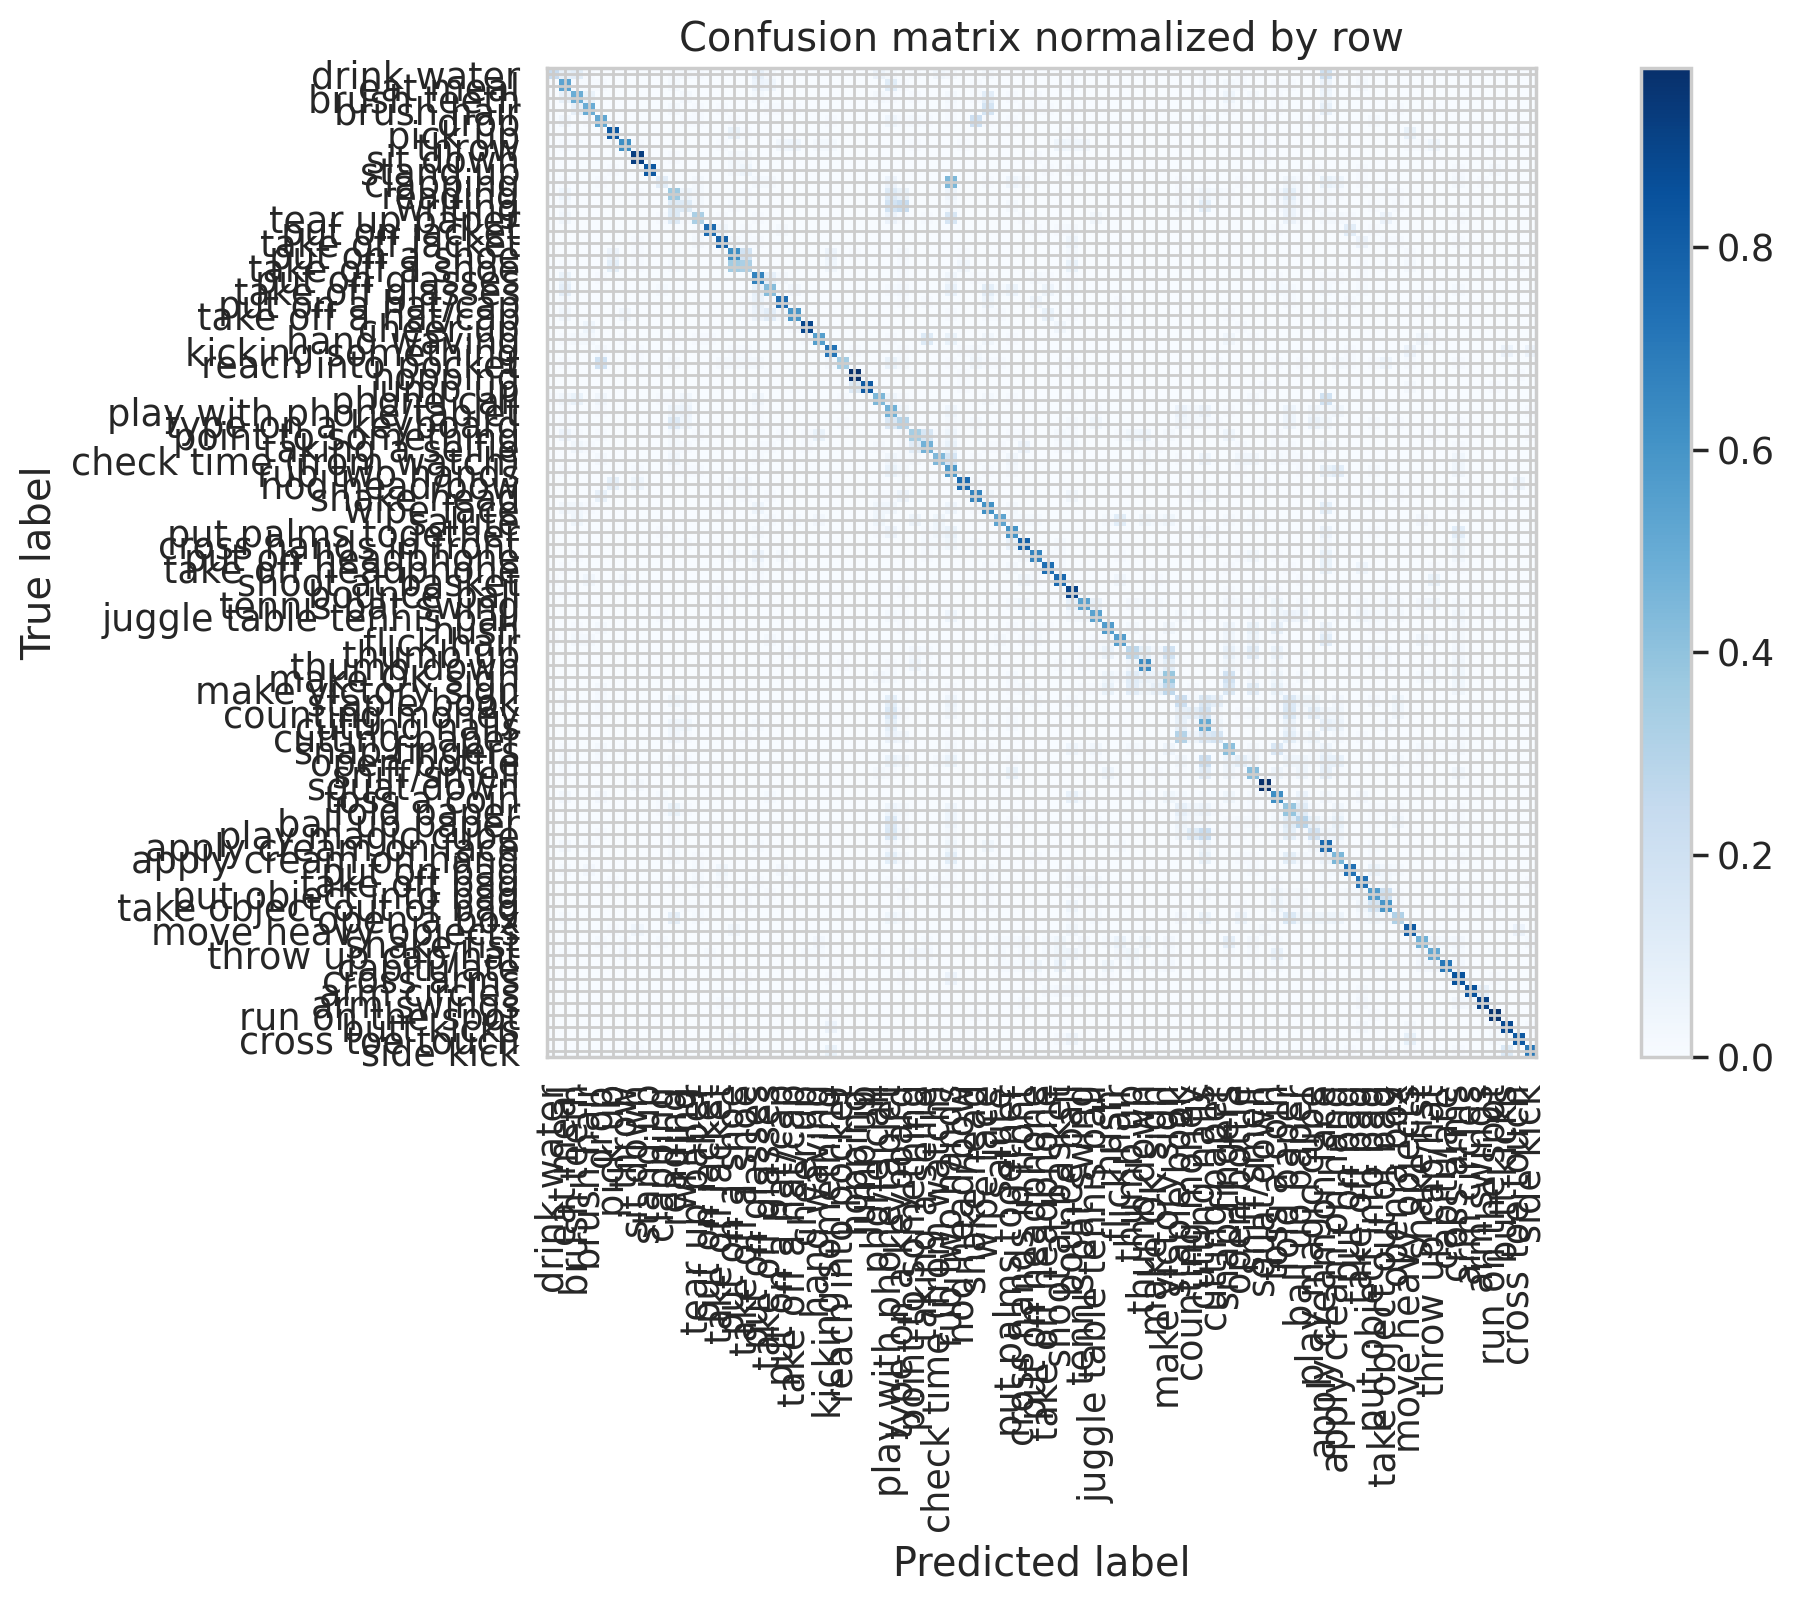

Overall accuracy: 0.562

                           precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      type on a keyboard       0.272      0.298      0.284      0.013         94|	 play with phone/tablet: 0.138,	reading: 0.128,	
        put on a hat/cap       0.824      0.745      0.782      0.013         94|	 put on glasses: 0.064,	wipe face: 0.043,	
                 jump up       1.000      0.817      0.899      0.013         93|	 hopping: 0.129,	move heavy objects: 0.022,	
  take object out of bag       0.545      0.591      0.567      0.013         93|	 put object into bag: 0.172,	bounce ball: 0.043,	
            take off bag       0.660      0.731      0.694      0.013         93|	 tear up paper: 0.022,	take off jacket: 0.022,	
           put on a shoe       0.491      0.620      0.548      0.013         92|	 take off a shoe: 0.185,	kicking something: 0.054,	
         take off a shoe       0.423      0.326      0.368      0.013         92|	 put on a shoe

In [42]:
best_model_wts = copy.deepcopy(bilstm_model.state_dict())
best_acc = 0.0
show_interval = 10

eval_metrics = eval_step(bilstm_model, val_dl,std_loss, device, class_names,  print_report=True, show_plot=True)

In [44]:
!rm -r checking_vids

In [45]:
save_vids_dir = "checking_vids/init"
for adata in tqdm(val_dl):
  selected_ind = random.randint(0,adata[0].shape[0]-1)
  data = adata[0][selected_ind]
  file_id = adata[4][selected_ind].split(".")[0]
  target = id2clsname[int(adata[2][selected_ind])]
  vid_size = [int(adata[3][0][selected_ind]),int(adata[3][1][selected_ind])]

  pred,_,pred_label = bilstm_model(data.repeat(batch_size,1,1).to(device))
  pred = pred[0].cpu().detach().numpy()
  pred_label = id2clsname[int(np.argmax(pred_label[0].cpu().detach().numpy()))]

  try:
    if not os.path.exists(f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4"):
      os.makedirs(f"{save_vids_dir}/{file_id}",exist_ok=True)
      gen_video(data.numpy(), 
                f"{save_vids_dir}/{file_id}/true_cls_{target}.mp4",
                vid_size[0], 
                vid_size[1],
                is_3d=False,
                mapping_list=joint_map
                )
      
      gen_video(pred, 
                f"{save_vids_dir}/{file_id}/pred_cls_{pred_label}.mp4",
                vid_size[0], 
                vid_size[1],
                is_3d=False,
                mapping_list=joint_map
                )
  except ValueError:
    continue

100%|██████████| 57/57 [01:59<00:00,  2.10s/it]


In [48]:
!zip -r checking_vids.zip checking_vids/

  adding: checking_vids/ (stored 0%)
  adding: checking_vids/init/ (stored 0%)
  adding: checking_vids/init/S004C002P003R001A007/ (stored 0%)
  adding: checking_vids/init/S004C002P003R001A007/pred_cls_throw.mp4 (deflated 97%)
  adding: checking_vids/init/S004C002P003R001A007/true_cls_throw.mp4 (deflated 56%)
  adding: checking_vids/init/S019C001P042R002A093/ (stored 0%)
  adding: checking_vids/init/S019C001P042R002A093/true_cls_shake fist.mp4 (deflated 58%)
  adding: checking_vids/init/S019C001P042R002A093/pred_cls_hand waving.mp4 (deflated 97%)
  adding: checking_vids/init/S031C001P067R002A077/ (stored 0%)
  adding: checking_vids/init/S031C001P067R002A077/pred_cls_snap fingers.mp4 (deflated 97%)
  adding: checking_vids/init/S031C001P067R002A077/true_cls_snap fingers.mp4 (deflated 60%)
  adding: checking_vids/init/S006C003P022R002A012/ (stored 0%)
  adding: checking_vids/init/S006C003P022R002A012/true_cls_writing.mp4 (deflated 67%)
  adding: checking_vids/init/S029C002P044R002A095/ (st